In [1]:
%matplotlib inline
from sqlalchemy import create_engine, inspect
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

In [2]:
engine = create_engine("sqlite:///../db/mlsseasons.sqlite", echo=False)
np.random.seed(1)
tf.random.set_seed(1)

In [3]:
dataset=pd.DataFrame(engine.execute("""
select s."First Name", s."Last Name", s.Position,
c.Club, c.pts, c."#" as standing, c.season, s."Total Compensation"
from seasons c
join club_map m on m.long_name = c.Club
join salaries s on s."Club (grouped)" = m.short_name
where c.season = s.Season
"""),columns=['First Name','Last Name','Position','Club','PTS','Standing','Season','Salary'])
dataset

,First Name,Last Name,Position,Club,PTS,Standing,Season,Salary
0,None,Carreiro da Silva Fred,M-F,DCD.C. United,55,1,2007,222008
1,Ben,Olsen,M,DCD.C. United,55,1,2007,177500
2,Brad,North,F,DCD.C. United,55,1,2007,12900
3,Brian,Carroll,M,DCD.C. United,55,1,2007,118750
4,Bryan,Arguez,M-D,DCD.C. United,55,1,2007,76200
...,...,...,...,...,...,...,...,...
6206,Quincy,Amarikwa,F,SJSan Jose Earthquakes,21,23,2018,289167
6207,Shea,Salinas,M,SJSan Jose Earthquakes,21,23,2018,200000
6208,Tommy,Thompson,M,SJSan Jose Earthquakes,21,23,2018,170000
6209,"Valeri ""Vako""",Qazaishvili,M,SJSan Jose Earthquakes,21,23,2018,1454042


In [4]:
engine.execute("select sqlite_version()").first()

('3.22.0',)

In [5]:
dataset["First Name"] = dataset["First Name"].fillna("")

In [6]:
dataset['Player'] = dataset['First Name'] + dataset['Last Name'] # + dataset['Position']
dataset['Team'] = dataset['Club'] + dataset['Season'].apply(str)
dataset['Salary'] = dataset['Salary'] / dataset['Salary'].max()
dataset

,First Name,Last Name,Position,Club,PTS,Standing,Season,Salary,Player,Team
0,,Carreiro da Silva Fred,M-F,DCD.C. United,55,1,2007,0.030974,Carreiro da Silva Fred,DCD.C. United2007
1,Ben,Olsen,M,DCD.C. United,55,1,2007,0.024765,BenOlsen,DCD.C. United2007
2,Brad,North,F,DCD.C. United,55,1,2007,0.001800,BradNorth,DCD.C. United2007
3,Brian,Carroll,M,DCD.C. United,55,1,2007,0.016568,BrianCarroll,DCD.C. United2007
4,Bryan,Arguez,M-D,DCD.C. United,55,1,2007,0.010631,BryanArguez,DCD.C. United2007
...,...,...,...,...,...,...,...,...,...,...
6206,Quincy,Amarikwa,F,SJSan Jose Earthquakes,21,23,2018,0.040344,QuincyAmarikwa,SJSan Jose Earthquakes2018
6207,Shea,Salinas,M,SJSan Jose Earthquakes,21,23,2018,0.027904,SheaSalinas,SJSan Jose Earthquakes2018
6208,Tommy,Thompson,M,SJSan Jose Earthquakes,21,23,2018,0.023718,TommyThompson,SJSan Jose Earthquakes2018
6209,"Valeri ""Vako""",Qazaishvili,M,SJSan Jose Earthquakes,21,23,2018,0.202866,"Valeri ""Vako""Qazaishvili",SJSan Jose Earthquakes2018


In [7]:
# Example on one player
subset = dataset.loc[dataset["Player"] == "BenOlsen"].sort_values("Season")
subset["Experience"] = range(subset.count()["Season"])
subset
#dataset.loc[dataset["Player"] == "BenOlsen"]

,First Name,Last Name,Position,Club,PTS,Standing,Season,Salary,Player,Team,Experience
1,Ben,Olsen,M,DCD.C. United,55,1,2007,0.024765,BenOlsen,DCD.C. United2007,0
627,Ben,Olsen,M,DCD.C. United,38,10,2008,0.029997,BenOlsen,DCD.C. United2008,1
1005,Ben,Olsen,M,DCD.C. United,40,10,2009,0.031392,BenOlsen,DCD.C. United2009,2


In [8]:
# Add a column to the dataset "Experience" - how many years the player was in MLS prior to the season
for player in pd.unique(dataset["Player"]):
    subset = dataset.loc[dataset["Player"] == player].sort_values("Season")
    subset["Experience"] = range(subset.count()["Season"])
    for season in subset["Season"]:
        exp = subset.loc[subset["Season"] == season]["Experience"].array[0]
        dataset.loc[((dataset["Player"] == player) & (dataset["Season"] == season)), ["Experience"]] = exp + 1
dataset


,First Name,Last Name,Position,Club,PTS,Standing,Season,Salary,Player,Team,Experience
0,,Carreiro da Silva Fred,M-F,DCD.C. United,55,1,2007,0.030974,Carreiro da Silva Fred,DCD.C. United2007,1.0
1,Ben,Olsen,M,DCD.C. United,55,1,2007,0.024765,BenOlsen,DCD.C. United2007,1.0
2,Brad,North,F,DCD.C. United,55,1,2007,0.001800,BradNorth,DCD.C. United2007,1.0
3,Brian,Carroll,M,DCD.C. United,55,1,2007,0.016568,BrianCarroll,DCD.C. United2007,1.0
4,Bryan,Arguez,M-D,DCD.C. United,55,1,2007,0.010631,BryanArguez,DCD.C. United2007,1.0
...,...,...,...,...,...,...,...,...,...,...,...
6206,Quincy,Amarikwa,F,SJSan Jose Earthquakes,21,23,2018,0.040344,QuincyAmarikwa,SJSan Jose Earthquakes2018,10.0
6207,Shea,Salinas,M,SJSan Jose Earthquakes,21,23,2018,0.027904,SheaSalinas,SJSan Jose Earthquakes2018,11.0
6208,Tommy,Thompson,M,SJSan Jose Earthquakes,21,23,2018,0.023718,TommyThompson,SJSan Jose Earthquakes2018,5.0
6209,"Valeri ""Vako""",Qazaishvili,M,SJSan Jose Earthquakes,21,23,2018,0.202866,"Valeri ""Vako""Qazaishvili",SJSan Jose Earthquakes2018,2.0


In [9]:
dataset.groupby("Player").count()["Season"].describe()

count    2250.000000
mean        2.758667
std         2.360747
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        12.000000
Name: Season, dtype: float64

In [10]:
from sklearn.preprocessing import LabelEncoder
player_names = dataset["Player"].tolist()
# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(player_names)
encoded_players = label_encoder.transform(player_names)
encoded_players

array([ 384,  231,  279, ..., 2122, 2165, 2222])

In [11]:
# Add the encoded player number to each player and a temp column 'present' for pivoting
dataset['encoded_player'] = encoded_players
dataset['present'] = 1.0

# As an example let's see how it looks like for one random player
dataset.loc[dataset['Player'] == 'BenOlsen']

,First Name,Last Name,Position,Club,PTS,Standing,Season,Salary,Player,Team,Experience,encoded_player,present
1,Ben,Olsen,M,DCD.C. United,55,1,2007,0.024765,BenOlsen,DCD.C. United2007,1.0,231,1.0
627,Ben,Olsen,M,DCD.C. United,38,10,2008,0.029997,BenOlsen,DCD.C. United2008,2.0,231,1.0
1005,Ben,Olsen,M,DCD.C. United,40,10,2009,0.031392,BenOlsen,DCD.C. United2009,3.0,231,1.0


In [12]:
# Create a multi-hot vector for each team-season playes reflecting the players participation
samples = dataset.pivot(index="Team", columns="encoded_player", values='present').fillna(0)
samples

encoded_player,0,1,2,3,4,5,6,7,8,9,...,2241,2242,2243,2244,2245,2246,2247,2248,2249,2250
Team,,,,,,,,,,,,,,,,,,,,,
ATLAtlanta United FC2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATLAtlanta United FC2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHIChicago Fire FC2007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHIChicago Fire FC2008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHIChicago Fire FC2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VANVancouver Whitecaps FC2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VANVancouver Whitecaps FC2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VANVancouver Whitecaps FC2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
samples.describe()

encoded_player,0,1,2,3,4,5,6,7,8,9,...,2241,2242,2243,2244,2245,2246,2247,2248,2249,2250
count,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,...,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000
mean,0.009174,0.045872,0.018349,0.004587,0.009174,0.004587,0.018349,0.013761,0.004587,0.022936,...,0.009174,0.004587,0.009174,0.027523,0.004587,0.004587,0.004587,0.009174,0.009174,0.018349
std,0.095562,0.209688,0.134517,0.067729,0.095562,0.067729,0.134517,0.116767,0.067729,0.150043,...,0.095562,0.067729,0.095562,0.163978,0.067729,0.067729,0.067729,0.095562,0.095562,0.134517
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
salaries = dataset.pivot(index="Team", columns="encoded_player", values='Salary').fillna(0)
salaries.describe()

encoded_player,0,1,2,3,4,5,6,7,8,9,...,2241,2242,2243,2244,2245,2246,2247,2248,2249,2250
count,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,...,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000
mean,0.000096,0.000934,0.000321,0.000011,0.000068,0.000043,0.000088,0.000135,0.000034,0.000197,...,0.000052,0.000220,0.000046,0.000484,0.000089,0.000060,0.000960,0.000215,0.000704,0.005027
std,0.000999,0.004794,0.002415,0.000167,0.000704,0.000638,0.000649,0.001156,0.000501,0.001299,...,0.000547,0.003244,0.000478,0.002922,0.001319,0.000886,0.014174,0.002240,0.009492,0.067830
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.010656,0.035228,0.022209,0.002469,0.007544,0.009418,0.005581,0.011231,0.007395,0.009719,...,0.005860,0.047890,0.005093,0.021207,0.019474,0.013080,0.209278,0.023439,0.139519,1.000000


In [15]:
experiences = dataset.pivot(index="Team", columns="encoded_player", values='Experience').fillna(0)
experiences.describe()

encoded_player,0,1,2,3,4,5,6,7,8,9,...,2241,2242,2243,2244,2245,2246,2247,2248,2249,2250
count,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,...,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.0
mean,0.013761,0.252294,0.045872,0.004587,0.013761,0.004587,0.045872,0.027523,0.004587,0.068807,...,0.013761,0.004587,0.013761,0.096330,0.004587,0.004587,0.004587,0.013761,0.013761,0.0
std,0.151166,1.307765,0.368965,0.067729,0.151166,0.067729,0.368965,0.252498,0.067729,0.498698,...,0.151166,0.067729,0.151166,0.640338,0.067729,0.067729,0.067729,0.151166,0.151166,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,2.000000,10.000000,4.000000,1.000000,2.000000,1.000000,4.000000,3.000000,1.000000,5.000000,...,2.000000,1.000000,2.000000,6.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.0


In [16]:
dataset['Standing'] = dataset['Standing'].astype(int)
dataset['PTS'] = dataset['PTS'].astype(int)

# Create a target vector to train the model on. Either on Standings or Points (PTS)
y = dataset.groupby('Team').mean()['Standing'].sort_index()
y

Team
ATLAtlanta United FC2017          4.0
ATLAtlanta United FC2018          2.0
CHIChicago Fire FC2007            8.0
CHIChicago Fire FC2008            3.0
CHIChicago Fire FC2009            6.0
                                 ... 
VANVancouver Whitecaps FC2014     9.0
VANVancouver Whitecaps FC2015     3.0
VANVancouver Whitecaps FC2016    16.0
VANVancouver Whitecaps FC2017     8.0
VANVancouver Whitecaps FC2018    14.0
Name: Standing, Length: 218, dtype: float64

In [17]:
# Create a sequence of input (training) data
X = samples.sort_index()
X

encoded_player,0,1,2,3,4,5,6,7,8,9,...,2241,2242,2243,2244,2245,2246,2247,2248,2249,2250
Team,,,,,,,,,,,,,,,,,,,,,
ATLAtlanta United FC2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATLAtlanta United FC2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHIChicago Fire FC2007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHIChicago Fire FC2008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHIChicago Fire FC2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VANVancouver Whitecaps FC2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VANVancouver Whitecaps FC2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VANVancouver Whitecaps FC2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Create a sequence of input (training) data of both participation AND experience
Xx = samples.join(salaries, rsuffix="e").fillna(0).sort_index()
Xx

encoded_player,0,1,2,3,4,5,6,7,8,9,...,2241e,2242e,2243e,2244e,2245e,2246e,2247e,2248e,2249e,2250e
Team,,,,,,,,,,,,,,,,,,,,,
ATLAtlanta United FC2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATLAtlanta United FC2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHIChicago Fire FC2007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHIChicago Fire FC2008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHIChicago Fire FC2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VANVancouver Whitecaps FC2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VANVancouver Whitecaps FC2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VANVancouver Whitecaps FC2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
Xs = salaries.sort_index()
Xs

encoded_player,0,1,2,3,4,5,6,7,8,9,...,2241,2242,2243,2244,2245,2246,2247,2248,2249,2250
Team,,,,,,,,,,,,,,,,,,,,,
ATLAtlanta United FC2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATLAtlanta United FC2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHIChicago Fire FC2007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHIChicago Fire FC2008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHIChicago Fire FC2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VANVancouver Whitecaps FC2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VANVancouver Whitecaps FC2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VANVancouver Whitecaps FC2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Use train_test_split to create training and testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(163, 2251) (55, 2251) (163,) (55,)


In [21]:
# first, create a normal neural network with 2 inputs, 6 hidden nodes, and 2 outputs

tf.keras.backend.clear_session()
model = Sequential()
model.add(Dense(units=20, activation='relu', input_dim=X_train.shape[-1]))
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                45040     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 45,901
Trainable params: 45,901
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [23]:
# Fit the model to the training data
history = model.fit(
    X_train,
    y_train,
    epochs=15,
    shuffle=True,
    verbose=1,
    validation_data=(X_test, y_test)
)

Epoch 1/15
6/6 [==============================] - 0s 40ms/step - loss: 129.0282 - accuracy: 0.0000e+00 - val_loss: 125.7191 - val_accuracy: 0.0000e+00
Epoch 2/15
6/6 [==============================] - 0s 7ms/step - loss: 127.3441 - accuracy: 0.0000e+00 - val_loss: 124.4731 - val_accuracy: 0.0000e+00
Epoch 3/15
6/6 [==============================] - 0s 6ms/step - loss: 125.8381 - accuracy: 0.0000e+00 - val_loss: 123.0842 - val_accuracy: 0.0000e+00
Epoch 4/15
6/6 [==============================] - 0s 6ms/step - loss: 123.8623 - accuracy: 0.0000e+00 - val_loss: 121.1328 - val_accuracy: 0.0000e+00
Epoch 5/15
6/6 [==============================] - 0s 6ms/step - loss: 121.2199 - accuracy: 0.0061 - val_loss: 118.3719 - val_accuracy: 0.0000e+00
Epoch 6/15
6/6 [==============================] - 0s 7ms/step - loss: 117.3459 - accuracy: 0.0429 - val_loss: 114.5273 - val_accuracy: 0.0182
Epoch 7/15
6/6 [==============================] - 0s 6ms/step - loss: 112.3515 - accuracy: 0.0675 - val_loss: 1

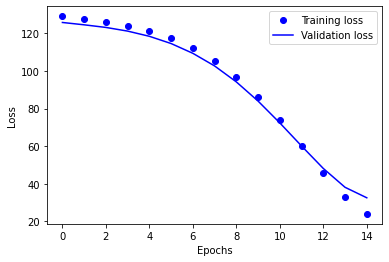

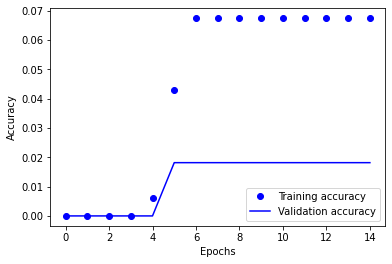

In [24]:
history_dict = history.history

plt.plot(history.epoch, history_dict['loss'], 'bo', label='Training loss')
plt.plot(history.epoch, history_dict['val_loss'], 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.epoch, history_dict['accuracy'], 'bo', label='Training accuracy')
plt.plot(history.epoch, history_dict['val_accuracy'], 'b', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
model_loss, model_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

2/2 - 0s - loss: 32.5781 - accuracy: 0.0182
Normal Neural Network - Loss: 32.578125, Accuracy: 0.0181818176060915


In [26]:
print("Model predicted:", model.predict(X_test.head(1)))
print("Actual value:", y_test.head(1))

Model predicted: [[10.984912]]
Actual value: Team
DCD.C. United2016    10.0
Name: Standing, dtype: float64


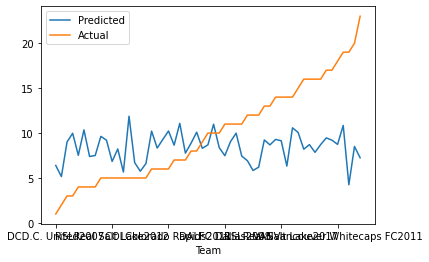

In [27]:
y_predicted = model.predict(X_test)

df_predict = pd.DataFrame(index=X_test.index)
df_predict['Predicted'] = y_predicted
df_predict['Actual'] = y_test
#df_predict['Error'] = np.abs(np.subtract(y_predicted.reshape(y_predicted.shape[0]), y_test.to_numpy()))

df_predict.sort_values("Actual").plot()
plt.show()

In [28]:
a = pd.DataFrame(df_predict[['Actual','Predicted']].sort_values("Actual"))
a['rownum'] = range(len(a))
a.loc[a['rownum'] > 50]

,Actual,Predicted,rownum
Team,,,
TORToronto FC2012,19.0,10.847609,51
TORToronto FC2018,19.0,4.243573,52
CHIChicago Fire FC2015,20.0,8.507214,53
SJSan Jose Earthquakes2018,23.0,7.245543,54


# Approach #2: encoded standings

In [29]:
# Approach #2: encoded standings
encoded_standings = dataset[['Team', 'Standing']].groupby('Team').max()
encoded_standings['taken'] = 1.0
encoded_standings

,Standing,taken
Team,,
ATLAtlanta United FC2017,4,1.0
ATLAtlanta United FC2018,2,1.0
CHIChicago Fire FC2007,8,1.0
CHIChicago Fire FC2008,3,1.0
CHIChicago Fire FC2009,6,1.0
...,...,...
VANVancouver Whitecaps FC2014,9,1.0
VANVancouver Whitecaps FC2015,3,1.0
VANVancouver Whitecaps FC2016,16,1.0


In [30]:
categorical_standings = encoded_standings.pivot(columns="Standing", values='taken').fillna(0).sort_index()
categorical_standings

Standing,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
Team,,,,,,,,,,,,,,,,,,,,,
ATLAtlanta United FC2017,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATLAtlanta United FC2018,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHIChicago Fire FC2007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHIChicago Fire FC2008,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHIChicago Fire FC2009,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VANVancouver Whitecaps FC2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VANVancouver Whitecaps FC2015,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VANVancouver Whitecaps FC2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, categorical_standings, random_state=2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(163, 2251) (55, 2251) (163, 23) (55, 23)


In [32]:
tf.keras.backend.clear_session()
cmodel = Sequential()
cmodel.add(Dense(units=10, activation='relu', input_dim=X_train.shape[-1]))
cmodel.add(Dense(units=10, activation='relu'))
cmodel.add(Dense(units=10, activation='relu'))
cmodel.add(Dense(units=encoded_standings['Standing'].max(), activation='softmax'))
cmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                22520     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 23)                253       
Total params: 22,993
Trainable params: 22,993
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Compile the model
cmodel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

In [34]:
# Fit the model to the training data
chistory = cmodel.fit(
    X_train,
    y_train,
    epochs=15,
    shuffle=True,
    verbose=1,
    validation_data=(X_test, y_test)
)

Epoch 1/15
6/6 [==============================] - 0s 41ms/step - loss: 3.1338 - accuracy: 0.0368 - val_loss: 3.1376 - val_accuracy: 0.0182
Epoch 2/15
6/6 [==============================] - 0s 6ms/step - loss: 3.1012 - accuracy: 0.0736 - val_loss: 3.1397 - val_accuracy: 0.0000e+00
Epoch 3/15
6/6 [==============================] - 0s 7ms/step - loss: 3.0752 - accuracy: 0.0982 - val_loss: 3.1430 - val_accuracy: 0.0000e+00
Epoch 4/15
6/6 [==============================] - 0s 6ms/step - loss: 3.0476 - accuracy: 0.0920 - val_loss: 3.1479 - val_accuracy: 0.0000e+00
Epoch 5/15
6/6 [==============================] - 0s 6ms/step - loss: 3.0175 - accuracy: 0.0920 - val_loss: 3.1545 - val_accuracy: 0.0000e+00
Epoch 6/15
6/6 [==============================] - 0s 6ms/step - loss: 2.9844 - accuracy: 0.1043 - val_loss: 3.1627 - val_accuracy: 0.0000e+00
Epoch 7/15
6/6 [==============================] - 0s 6ms/step - loss: 2.9470 - accuracy: 0.1166 - val_loss: 3.1715 - val_accuracy: 0.0000e+00
Epoch 8/1

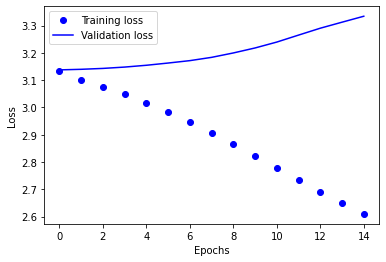

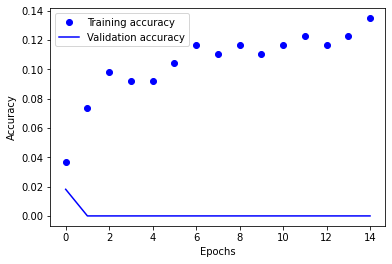

In [35]:
chistory_dict = chistory.history

plt.plot(chistory.epoch, chistory_dict['loss'], 'bo', label='Training loss')
plt.plot(chistory.epoch, chistory_dict['val_loss'], 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(chistory.epoch, chistory_dict['accuracy'], 'bo', label='Training accuracy')
plt.plot(chistory.epoch, chistory_dict['val_accuracy'], 'b', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()